In [1]:
import os
import cv2
import numpy as np

# Define paths
data_dir = 'backupbig/'
groups = os.listdir(data_dir)

# Initialize lists to store features and labels
cropped_face_images = []
original_images = []
left_eye_images = []
right_eye_images = []
labels = []

# all required preprocessing methods
def apply_gamma_correction(image, gamma):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read image at path: {image_path}")
        return None
    
    # Apply gamma correction
    image = apply_gamma_correction(image, gamma=1.5)
    
    # Convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Resize the image to a fixed size if necessary
    image = cv2.resize(image, (227, 227))
    
    # Normalize the pixel values
    image = image / 255.0
    
    return image

def preprocess_eye_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"{image_path}")
        return None
    
    # Apply gamma correction
    image = apply_gamma_correction(image, gamma=1.5)
    
    # Resize the image to 30x30
    image = cv2.resize(image, (30, 30))
    
    # Convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Normalize the pixel values
    image = image / 255.0
    
    return image

# Function to preprocess labels
def preprocess_label(label_path):
    with open(label_path, 'r') as file:
        line = file.readline().strip()
        # Remove the parentheses and split the string by comma
        coordinates = line.strip('()').split(',')
        # Convert the coordinates to floats
        coordinates = [int(coord.strip()) for coord in coordinates]
    return coordinates

# Iterate through each group folder
for group in groups:
    group_dir = os.path.join(data_dir, group)
    if os.path.isdir(group_dir):
        # Read features
        original_image_path = os.path.join(group_dir, 'original_image.jpg')
        cropped_face_path = os.path.join(group_dir, 'cropped_face.jpg')
        left_eye_path = os.path.join(group_dir, 'left_eye.jpg')
        right_eye_path = os.path.join(group_dir, 'right_eye.jpg')
        
        # Preprocess images
        original_image = preprocess_image(original_image_path)
        cropped_face = preprocess_image(cropped_face_path)
        left_eye = preprocess_eye_image(left_eye_path)
        right_eye = preprocess_eye_image(right_eye_path)
        
        # Append images to their corresponding lists
        original_images.append(original_image)
        cropped_face_images.append(cropped_face)
        left_eye_images.append(left_eye)
        right_eye_images.append(right_eye)
        
        # Read and preprocess label
        label_path = os.path.join(group_dir, 'labels.txt')
        label = preprocess_label(label_path)
        labels.append(label)

# Convert lists to numpy arrays
original_images = np.array(original_images)
cropped_face_images = np.array(cropped_face_images)
left_eye_images = np.array(left_eye_images)
right_eye_images = np.array(right_eye_images)
labels = np.array(labels)

# Shuffle the data
indices = np.arange(len(labels))
np.random.shuffle(indices)
original_images = original_images[indices]
cropped_face_images = cropped_face_images[indices]
left_eye_images = left_eye_images[indices]
right_eye_images = right_eye_images[indices]
labels = labels[indices]

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_original_train, X_original_test, X_cropped_face_train, X_cropped_face_test, X_left_eye_train, X_left_eye_test, X_right_eye_train, X_right_eye_test, y_train, y_test = train_test_split(original_images, cropped_face_images, left_eye_images, right_eye_images, labels, test_size=0.3, random_state=42)

# Now you can use these arrays in your model

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow import keras

In [3]:
import tensorflow as tf

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check if GPU is available
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.16.1
GPU available: []


# Usual Model

In [4]:

# Define input shapes
original_image_height, original_image_width, original_image_channels = 227, 227, 1
cropped_face_height, cropped_face_width, cropped_face_channels = 227, 227, 1
left_eye_height, left_eye_width, left_eye_channels = 30, 30, 1
right_eye_height, right_eye_width, right_eye_channels = 30, 30, 1

# Define input layers for each input
original_image_input = layers.Input(shape=(original_image_height, original_image_width, original_image_channels))
cropped_face_input = layers.Input(shape=(cropped_face_height, cropped_face_width, cropped_face_channels))
left_eye_input = layers.Input(shape=(left_eye_height, left_eye_width, left_eye_channels))
right_eye_input = layers.Input(shape=(right_eye_height, right_eye_width, right_eye_channels))

# Convolutional layers for original image
conv1_original = layers.Conv2D(32, (3, 3), activation='relu')(original_image_input)
pool1_original = layers.MaxPooling2D((2, 2))(conv1_original)
conv2_original = layers.Conv2D(64, (3, 3), activation='relu')(pool1_original)
pool2_original = layers.MaxPooling2D((2, 2))(conv2_original)
conv3_original = layers.Conv2D(64, (3, 3), activation='relu')(pool2_original)
flat1_original = layers.Flatten()(conv3_original)

# Convolutional layers for cropped face
conv1_cropped = layers.Conv2D(32, (3, 3), activation='relu')(cropped_face_input)
pool1_cropped = layers.MaxPooling2D((2, 2))(conv1_cropped)
conv2_cropped = layers.Conv2D(64, (3, 3), activation='relu')(pool1_cropped)
pool2_cropped = layers.MaxPooling2D((2, 2))(conv2_cropped)
conv3_cropped = layers.Conv2D(64, (3, 3), activation='relu')(pool2_cropped)
flat1_cropped = layers.Flatten()(conv3_cropped)

# Convolutional layers for left eye
conv1_left_eye = layers.Conv2D(32, (3, 3), activation='relu')(left_eye_input)
pool1_left_eye = layers.MaxPooling2D((2, 2))(conv1_left_eye)
conv2_left_eye = layers.Conv2D(64, (3, 3), activation='relu')(pool1_left_eye)
pool2_left_eye = layers.MaxPooling2D((2, 2))(conv2_left_eye)
conv3_left_eye = layers.Conv2D(64, (3, 3), activation='relu')(pool2_left_eye)
flat1_left_eye = layers.Flatten()(conv3_left_eye)

# Convolutional layers for right eye
conv1_right_eye = layers.Conv2D(32, (3, 3), activation='relu')(right_eye_input)
pool1_right_eye = layers.MaxPooling2D((2, 2))(conv1_right_eye)
conv2_right_eye = layers.Conv2D(64, (3, 3), activation='relu')(pool1_right_eye)
pool2_right_eye = layers.MaxPooling2D((2, 2))(conv2_right_eye)
conv3_right_eye = layers.Conv2D(64, (3, 3), activation='relu')(pool2_right_eye)
flat1_right_eye = layers.Flatten()(conv3_right_eye)

# Concatenate the outputs of convolutional layers
concatenated = layers.concatenate([flat1_original, flat1_cropped, flat1_left_eye, flat1_right_eye])

# Define fully connected layers
dense1 = layers.Dense(64, activation='relu')(concatenated)
output = layers.Dense(2)(dense1)  # Output layer, assuming 2 coordinates for gaze tracking

# Define the model
model = models.Model(inputs=[original_image_input, cropped_face_input, left_eye_input, right_eye_input], outputs=output)

# Print model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 227, 227, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, 227, 227, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_2 (InputLayer)    │ (None, 30, 30, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_3 (InputLayer)    │ (None, 30, 30, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 225, 225, 32)      │             320 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 225, 225, 32)      │             320 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 28, 28, 32)        │             320 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 28, 28, 32)        │             320 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 112, 112, 32)      │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 112, 112, 32)      │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 14, 14, 32)        │               0 │ conv2d_6[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_6               │ (None, 14, 14, 32)        │               0 │ conv2d_9[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 110, 110, 64)      │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 110, 110, 64)      │          18,496 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 12, 12, 64)        │          18,496 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_10 (Conv2D)            │ (None, 12, 12, 64)        │          18,49

 Total params: 23,365,570 (89.13 MB)

 Trainable params: 23,365,570 (89.13 MB)

 Non-trainable params: 0 (0.00 B)

# Better Model

In [3]:
from tensorflow.keras import layers, models, regularizers

# Define input shapes
original_image_height, original_image_width, original_image_channels = 227, 227, 1
cropped_face_height, cropped_face_width, cropped_face_channels = 227, 227, 1
left_eye_height, left_eye_width, left_eye_channels = 30, 30, 1
right_eye_height, right_eye_width, right_eye_channels = 30, 30, 1

# Define regularization strengths
l2_reg = regularizers.l2(0.1)  # Start with a small value
l1_reg = regularizers.l1(0.1)  # Start with a small value

# Define input layers for each input
original_image_input = layers.Input(shape=(original_image_height, original_image_width, original_image_channels))
cropped_face_input = layers.Input(shape=(cropped_face_height, cropped_face_width, cropped_face_channels))
left_eye_input = layers.Input(shape=(left_eye_height, left_eye_width, left_eye_channels))
right_eye_input = layers.Input(shape=(right_eye_height, right_eye_width, right_eye_channels))

# Convolutional layers for original image
conv1_original = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2_reg)(original_image_input)
pool1_original = layers.MaxPooling2D((2, 2))(conv1_original)
conv2_original = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2_reg)(pool1_original)
pool2_original = layers.MaxPooling2D((2, 2))(conv2_original)
conv3_original = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2_reg)(pool2_original)
flat1_original = layers.Flatten()(conv3_original)

# Convolutional layers for cropped face
conv1_cropped = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2_reg)(cropped_face_input)
pool1_cropped = layers.MaxPooling2D((2, 2))(conv1_cropped)
conv2_cropped = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2_reg)(pool1_cropped)
pool2_cropped = layers.MaxPooling2D((2, 2))(conv2_cropped)
conv3_cropped = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2_reg)(pool2_cropped)
flat1_cropped = layers.Flatten()(conv3_cropped)

# Convolutional layers for left eye
conv1_left_eye = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l1_reg)(left_eye_input)
pool1_left_eye = layers.MaxPooling2D((2, 2))(conv1_left_eye)
conv2_left_eye = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l1_reg)(pool1_left_eye)
pool2_left_eye = layers.MaxPooling2D((2, 2))(conv2_left_eye)
conv3_left_eye = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l1_reg)(pool2_left_eye)
flat1_left_eye = layers.Flatten()(conv3_left_eye)

# Convolutional layers for right eye
conv1_right_eye = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l1_reg)(right_eye_input)
pool1_right_eye = layers.MaxPooling2D((2, 2))(conv1_right_eye)
conv2_right_eye = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l1_reg)(pool1_right_eye)
pool2_right_eye = layers.MaxPooling2D((2, 2))(conv2_right_eye)
conv3_right_eye = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l1_reg)(pool2_right_eye)
flat1_right_eye = layers.Flatten()(conv3_right_eye)

# Concatenate the outputs of convolutional layers
concatenated = layers.concatenate([flat1_original, flat1_cropped, flat1_left_eye, flat1_right_eye])

# Define fully connected layers with regularization
dense1 = layers.Dense(64, activation='relu', kernel_regularizer=l2_reg)(concatenated)
output = layers.Dense(2, kernel_regularizer=l2_reg)(dense1)  # Output layer, assuming 2 coordinates for gaze tracking

# Define the model
model = models.Model(inputs=[original_image_input, cropped_face_input, left_eye_input, right_eye_input], outputs=output)

# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 227, 227, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, 227, 227, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_2 (InputLayer)    │ (None, 30, 30, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_3 (InputLayer)    │ (None, 30, 30, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 225, 225, 32)      │             320 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 225, 225, 32)      │             320 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 28, 28, 32)        │             320 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 28, 28, 32)        │             320 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 112, 112, 32)      │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 112, 112, 32)      │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 14, 14, 32)        │               0 │ conv2d_6[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_6               │ (None, 14, 14, 32)        │               0 │ conv2d_9[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 110, 110, 64)      │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 110, 110, 64)      │          18,496 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 12, 12, 64)        │          18,496 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_10 (Conv2D)            │ (None, 12, 12, 64)        │          18,49

 Total params: 23,365,570 (89.13 MB)

 Trainable params: 23,365,570 (89.13 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
from tensorflow.keras.losses import Huber
# 
model.compile(optimizer='adam', loss=Huber(), metrics=['accuracy'])

In [5]:
callback = keras.callbacks.EarlyStopping(monitor='loss',
                                              patience=11,
                                        start_from_epoch=4)

In [ ]:
history = model.fit([X_original_train, X_cropped_face_train, X_left_eye_train, X_right_eye_train],
                    y_train, 
                    epochs=200, 
                    validation_data=([X_original_test, X_cropped_face_test, X_left_eye_test, X_right_eye_test], 
                                     y_test),
                    callbacks=[callback],
                    validation_batch_size = 32,
                    batch_size=32
                   )

Epoch 1/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.7811 - loss: 540.2525 - val_accuracy: 0.7791 - val_loss: 368.8099
Epoch 2/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 371s 1s/step - accuracy: 0.7840 - loss: 345.4745 - val_accuracy: 0.7791 - val_loss: 329.7358
Epoch 3/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - accuracy: 0.7866 - loss: 338.3204 - val_accuracy: 0.7791 - val_loss: 315.8297
Epoch 4/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 364s 1s/step - accuracy: 0.7825 - loss: 318.0642 - val_accuracy: 0.8009 - val_loss: 300.5704
Epoch 5/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 364s 1s/step - accuracy: 0.7997 - loss: 300.7843 - val_accuracy: 0.8206 - val_loss: 280.9089
Epoch 6/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 372s 1s/step - accuracy: 0.8234 - loss: 285.1738 - val_accuracy: 0.8430 - val_loss: 266.4104
Epoch 7/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.8345 - loss: 274.9536 - val_accuracy: 0.8330 - val_loss: 287.9959
Epoch 8/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 366s 1s/step - accura

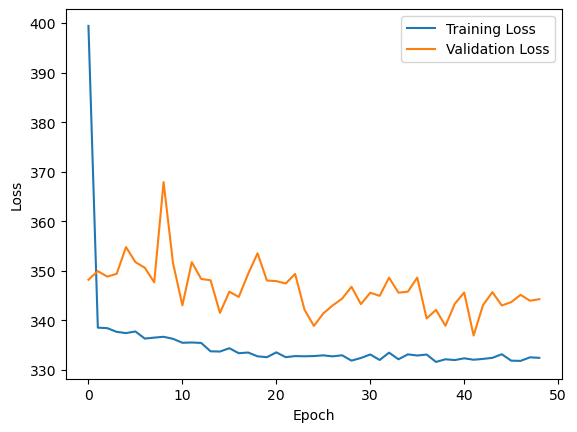

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

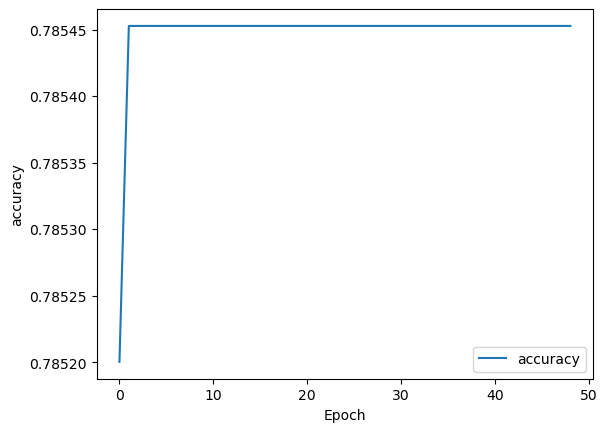

In [8]:
import matplotlib.pyplot as plt
#plt.plot(history.history['loss'], label='Training Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [9]:
preds = model.predict([X_original_test, X_cropped_face_test, X_left_eye_test, X_right_eye_test])

107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step


In [10]:
preds = np.round(preds).astype(int)

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Assuming 'preds' contains the model predictions and 'y_test' contains the true labels
# preds and y_test should be numpy arrays of the same shape

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, preds)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, preds)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Squared Error (MSE): 176615.69837997053
Mean Absolute Error (MAE): 343.70456553755525
Root Mean Squared Error (RMSE): 420.25670533612015


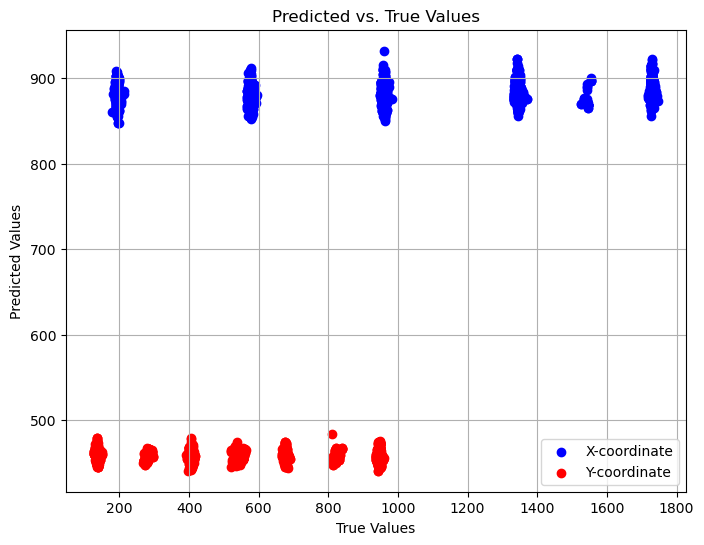

In [13]:
import matplotlib.pyplot as plt

# Plotting predicted vs. true values
plt.figure(figsize=(8, 6))
plt.scatter(y_test[:, 0], preds[:, 0], color='blue', label='X-coordinate')
plt.scatter(y_test[:, 1], preds[:, 1], color='red', label='Y-coordinate')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. True Values')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
model.save('Model5s.keras')

In [15]:
preds

array([[ 635,  605],
       [1666,  838],
       [ 700,  154],
       ...,
       [1047,  181],
       [1039,  321],
       [ 905,  599]])